<a href="https://colab.research.google.com/github/LeoDinga/DL_Project/blob/main/train_type2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install OpenMIM
# !pip install -U openmim

# # Use mim to install mmcv and mmengine
# !mim install "mmengine>=0.9.0"
# # Ensure you are picking a compatible mmcv version (e.g., >=2.0.0,<2.2.0)
# !pip install "mmcv>=2.0.0,<2.2.0" -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.1/index.html


Looking in links: https://download.openmmlab.com/mmcv/dist/cpu/torch2.6.0/index.html
  Using cached mmengine-0.10.7-py3-none-any.whl.metadata (20 kB)
Using cached mmengine-0.10.7-py3-none-any.whl (452 kB)
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.1/index.html
  Using cached https://download.openmmlab.com/mmcv/dist/cu118/torch2.1.0/mmcv-2.1.0-cp311-cp311-manylinux1_x86_64.whl (99.4 MB)


In [1]:
!pip uninstall -y torch torchvision torchao torchaudio torchtext torchdata
!pip uninstall -y mmcv mmcv-full mmengine mmaction2 transformers


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchao 0.10.0
Uninstalling torchao-0.10.0:
  Successfully uninstalled torchao-0.10.0
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: torchdata 0.11.0
Uninstalling torchdata-0.11.0:
  Successfully uninstalled torchdata-0.11.0
Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3


In [13]:
!pip install -U openmim
!mim install mmengine
!mim install 'mmcv==2.1.0'
!pip install torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers==4.35.2
!pip install mmaction2


Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.7/452.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 23.4 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.0 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118


Extrair os keypoints e visualizar



Ações disponíveis: ['backhand_slice', 'forehand_volley', 'backhand_volley', 'kick_service', 'slice_service', 'smash', 'backhand', 'flat_service', 'forehand_openstands', 'forehand_flat', 'backhand2hands', 'forehand_slice']
Exemplo de vídeo: p11_bslice_s3
Formato dos keypoints: (120, 33, 3)


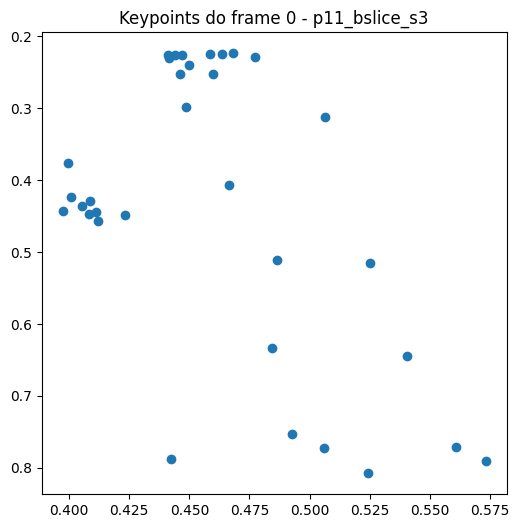

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Caminho para o ficheiro de keypoints
keypoints_path = "/content/all_keypoints.npz"

# Carregar os keypoints do ficheiro npz e reconstruir o dicionário
data = np.load(keypoints_path)
all_keypoints = {}
for key in data.files:
    action, video_file = key.split("__", 1)
    if action not in all_keypoints:
        all_keypoints[action] = {}
    all_keypoints[action][video_file] = data[key]

# Explorar os dados
print("Ações disponíveis:", list(all_keypoints.keys()))
first_action = list(all_keypoints.keys())[0]
first_video = list(all_keypoints[first_action].keys())[0]

print("Exemplo de vídeo:", first_video)
print("Formato dos keypoints:", all_keypoints[first_action][first_video].shape)

# Visualizar os keypoints de um frame
frame_idx = 0
keypoints = all_keypoints[first_action][first_video][frame_idx]

x = [pt[0] for pt in keypoints]
y = [pt[1] for pt in keypoints]

plt.figure(figsize=(6, 6))
plt.scatter(x, y)
plt.gca().invert_yaxis()
plt.title(f"Keypoints do frame {frame_idx} - {first_video}")
plt.show()


## obter as amostras de treino, teste e validação para o treino

In [8]:
from collections import defaultdict
from sklearn.model_selection import train_test_split
import random


def extract_player_id(filename):
    # Example: 'player1_video1.npy' → 'player1'
    return filename.split('_')[0]

# Organize videos by player
player_video_map = defaultdict(list)
for action, videos in all_keypoints.items():
    for video_file in videos:
        player_id = extract_player_id(video_file)
        player_video_map[player_id].append((action, video_file))

# Split player IDs
players = list(player_video_map.keys())
random.shuffle(players)

train_end = int(len(players) * 0.7)
val_end = int(len(players) * 0.85)

train_players = players[:train_end]
val_players = players[train_end:val_end]
test_players = players[val_end:]

def collect_by_players(player_ids):
    dataset = []
    for pid in player_ids:
        for action, filename in player_video_map[pid]:
            keypoints = all_keypoints[action][filename]
            dataset.append((keypoints, action))
    return dataset

train_set = collect_by_players(train_players)
val_set = collect_by_players(val_players)
test_set = collect_by_players(test_players)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Train: 1368, Val: 288, Test: 324


In [9]:
# N = number of samples, # C = 3 (x, y, z), # T = 120 (our fixed number of frames), # V = 33 (MediaPipe joints), # M = number of people
#Prepare data to STGCN (Store keypoints in a numpy array with the shape [N, C, T, V, M])
#Save the labels as integers in a separate pkl file.

import pickle

ntu_joints_in_mediapipe = [
    0,   # Nose
    11,  # Left Shoulder
    12,  # Right Shoulder
    13,  # Left Elbow
    14,  # Right Elbow
    15,  # Left Wrist
    16,  # Right Wrist
    23,  # Left Hip
    24,  # Right Hip
    25,  # Left Knee
    26,  # Right Knee
    27,  # Left Ankle
    28,  # Right Ankle
    5,   # Right Eye
    2,   # Left Eye
    7,   # Left Ear
    8,   # Right Ear
    17,  # Left Pinky
    18,  # Right Pinky
    19,  # Left Index
    20,  # Right Index
    21,  # Left Thumb
    22,  # Right Thumb
    29,  # Left Foot Index
    30   # Right Foot Index
]

def filter_to_ntu_joints(keypoints): #para usar layout NTU RGB+D
    # keypoints: (T, 33, C)
    return keypoints[:, ntu_joints_in_mediapipe, :]

def prepare_stgcn_data(dataset, label_map):
    data_list = []
    for i, (keypoints, action_name) in enumerate(dataset):
        keypoints = np.array(keypoints)  # (T, 33, C)
        keypoints = filter_to_ntu_joints(keypoints)  # (T, 25, C)
        num_frames, num_joints, channels = keypoints.shape
        # Se só tem 1 pessoa por sample:
        keypoints = keypoints[np.newaxis, ...]  # (M=1, T, V, C)
        # Se tiver keypoint_score, pode adicionar aqui
        sample = {
            'frame_dir': f'sample_{i}',
            'label': label_map[action_name],
            'img_shape': None,           # ou (H, W) se souber
            'total_frames': num_frames,
            'keypoint': keypoints,       # (M, T, V, C)
            # 'keypoint_score': np.ones_like(keypoints[..., 0]),  # opcional
        }
        data_list.append(sample)
    return data_list

# Crie o label_map como já fazia
label_map = {name: idx for idx, name in enumerate(sorted(set(a for _, a in train_set + val_set + test_set)))}

# Prepare os dados no formato correto
train_data = prepare_stgcn_data(train_set, label_map)
val_data = prepare_stgcn_data(val_set, label_map)
test_data = prepare_stgcn_data(test_set, label_map)

with open('/content/train_labels.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open('/content/val_labels.pkl', 'wb') as f:
    pickle.dump(val_data, f)


with open('/content/test_labels.pkl', 'wb') as f:
    pickle.dump(test_data, f)

print("Data saved successfully!")

Data saved successfully!


In [13]:
# Exemplo para MMAction2
!git clone https://github.com/open-mmlab/mmaction2.git mmaction2 #alterei
%cd mmaction2
!pip install -e .

fatal: destination path 'mmaction2' already exists and is not an empty directory.
/content/mmaction2
Obtaining file:///content/mmaction2
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmaction2
    Found existing installation: mmaction2 1.2.0
    Uninstalling mmaction2-1.2.0:
      Successfully uninstalled mmaction2-1.2.0
  Running setup.py develop for mmaction2


In [11]:
!pip install --force-reinstall numpy==1.26.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires torchdata==0.11.0, which is not installed.
yfinance 0.2.61 requires requests>=2.31, but you have requests 2.28.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
pymc 5.22.0 requires rich>=13.7.1, but you have rich 13.4.2 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.35.2 which is incompatible.
pytensor 2.30.3 requires filelock>=3.15, but you have fileloc

In [ ]:
import numpy
print(numpy.__version__)


In [1]:
import torch
import mmcv
import mmengine
import mmaction2


In [2]:

freez_code = """

from mmengine.registry import HOOKS
from mmengine.hooks import Hook

@HOOKS.register_module()
class FreezeSTGCNLayersHook(Hook):
    def before_train(self, runner):
        for name, param in runner.model.backbone.named_parameters():
            if 'layers.9' not in name:  # Ajusta conforme necessário
                param.requires_grad = False

"""

with open('/content/mmaction2/freeze_stgcn_layers_hook.py', 'w') as f:
    f.write(freez_code)


In [3]:
import sys
sys.path.append('/content/mmaction2')


In [4]:
### original diana

config_code = """

_base_ = ['/content/mmaction2/configs/_base_/default_runtime.py']

# Modelo ST-GCN com keypoints 3D
model = dict(
    type='RecognizerGCN',
    backbone=dict(
        type='STGCN',
        graph_cfg=dict(
            layout='nturgb+d',  # usa o layout NTU para dados 3D
            mode='spatial'),
        in_channels=3  # keypoints 3D: x, y, z
    ),
    cls_head=dict(
        type='GCNHead',
        in_channels=256,
        num_classes=12,  # <- alterado para o teu número de classes
        loss_cls=dict(type='CrossEntropyLoss'),
    ),
)


custom_imports = dict(
    imports=['freeze_stgcn_layers_hook'],
    allow_failed_imports=False)

train_pipeline = [
    dict(type='PreNormalize3D'),
    dict(type='GenSkeFeat', dataset='nturgb+d', feats=['j']),
    dict(type='UniformSampleFrames', clip_len=100),
    dict(type='PoseDecode'),
    dict(type='FormatGCNInput', num_person=2),
    dict(type='PackActionInputs')
]
val_pipeline = [
    dict(type='PreNormalize3D'),
    dict(type='GenSkeFeat', dataset='nturgb+d', feats=['j']),
    dict(
        type='UniformSampleFrames', clip_len=100, num_clips=1, test_mode=True),
    dict(type='PoseDecode'),
    dict(type='FormatGCNInput', num_person=2),
    dict(type='PackActionInputs')
]
test_pipeline = [
    dict(type='PreNormalize3D'),
    dict(type='GenSkeFeat', dataset='nturgb+d', feats=['j']),
    dict(
        type='UniformSampleFrames', clip_len=100, num_clips=10,
        test_mode=True),
    dict(type='PoseDecode'),
    dict(type='FormatGCNInput', num_person=2),
    dict(type='PackActionInputs')
]

train_dataloader = dict(
    batch_size=64,  # ALTERADO: era 16, agora 4 para teste rápido
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=dict(
        type='PoseDataset',
        ann_file='/content/train_labels.pkl',  # ALTERADO: caminho absoluto, antes era 'train_labels.pkl'
        pipeline=train_pipeline
    )
)
val_dataloader = dict(
    batch_size=64,  # ALTERADO: era 16, agora 4 para teste rápido
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type='PoseDataset',
        ann_file='/content/val_labels.pkl',  # ALTERADO: caminho absoluto, antes era 'val_labels.pkl'
        pipeline=val_pipeline
    )
)
test_dataloader = dict(
    batch_size=64,  # ALTERADO: era 16, agora 4 para teste rápido
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type='PoseDataset',
        ann_file='/content/test_labels.pkl',  # ALTERADO: caminho absoluto, antes era 'test_labels.pkl'
        pipeline=test_pipeline
    )
)

# val_evaluator = dict(type='AccMetric')
# test_evaluator = val_evaluator

val_evaluator = dict(
    type='AccMetric',
    metric_list=('top_k_accuracy', 'mean_class_accuracy')
)
test_evaluator = val_evaluator

# Wrapper do otimizador
optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(type='Adam', lr=0.0005, weight_decay=0.0001)
)


# Treino
train_cfg = dict(
    type='EpochBasedTrainLoop', max_epochs=50, val_interval=2  # ALTERADO: max_epochs era 80 (ou valor maior), agora 10; val_interval era 5, agora 2
)


# Avaliação
val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')


# evaluation = dict(
#     interval=5,
#     metrics=['top_k_accuracy', 'mean_class_accuracy']
# )

# evaluation = dict(
#     interval=2,
#     metrics=['top_k_accuracy', 'mean_class_accuracy'],
#     topk=(1, 3, 5)
# )



evaluation = dict(
    interval=2,
    metrics=['top_k_accuracy', 'mean_class_accuracy'])


custom_hooks = [
    dict(
        type='FreezeSTGCNLayersHook',
        priority='VERY_HIGH'
    )
]



# Salvar checkpoints, logs, etc.
#work_dir = '/content/mmaction2/stgcn_treino'
# work_dir = '/content/drive/MyDrive/mmaction2_work_dir/stgcn_treino'   # ALTERADO: era './work_dirs/stgcn_3d_custom_test'
work_dir = '/content/drive/MyDrive/mmaction2_work_dir_10/stgcn_treino'

load_from = 'https://download.openmmlab.com/mmaction/v1.0/skeleton/stgcn/stgcn_8xb16-joint-u100-80e_ntu60-xsub-keypoint-3d/stgcn_8xb16-joint-u100-80e_ntu60-xsub-keypoint-3d_20221129-850308e1.pth'







"""



# Gravar para o ficheiro na pasta configs/stgcn/
with open('/content/mmaction2/configs/stgcn_3d_custom.py', 'w') as f:
    f.write(config_code)





In [6]:
from google.colab import drive
import os
drive.mount('/content/drive')


save_path = '/content/drive/MyDrive/mmaction2_FINAL/stgcn_treino'
os.makedirs(save_path, exist_ok=True)




# os.makedirs('/content/drive/MyDrive/mmaction2_work_dir/tensorboard_logs', exist_ok=True)

Mounted at /content/drive


In [8]:
!python /content/mmaction2/tools/train.py /content/mmaction2/configs/stgcn_3d_custom.py


05/26 21:21:19 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 2066292127
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_

## Testar

In [12]:
!python /content/mmaction2/tools/test.py /content/mmaction2/configs/stgcn_3d_custom.py /content/drive/MyDrive/mmaction2_work_dir_10/stgcn_treino/epoch_50.pth --dump /content/drive/MyDrive/mmaction2_work_dir_10/stgcn_test/results.pkl


05/26 21:37:40 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 591211573
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_3

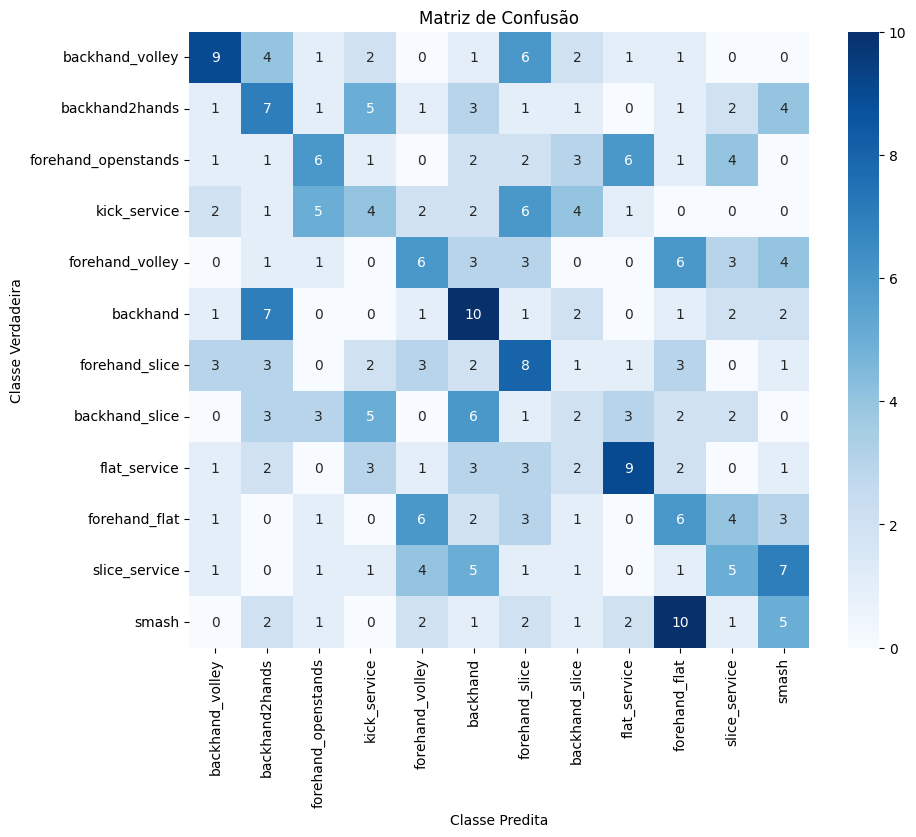

In [15]:
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Caminho para o ficheiro de resultados
results_path = '/content/drive/MyDrive/mmaction2_work_dir_10/stgcn_test/results.pkl'

# Carrega as predições
with open(results_path, 'rb') as f:
    results = pickle.load(f)

# results é normalmente uma lista de arrays de scores por classe
# Para cada amostra, o índice do maior score é a predição do modelo
# y_pred = [np.argmax(r) for r in results]

y_pred = [int(r['pred_label'].item()) if hasattr(r['pred_label'], 'item') else int(r['pred_label']) for r in results]


# Agora precisas dos rótulos verdadeiros (labels do dataset de teste)
# Supondo que tens um ficheiro ann_file com os labels:
import mmcv
ann_file = '/content/test_labels.pkl'

import pickle

with open('/content/test_labels.pkl', 'rb') as f:
    data_infos = pickle.load(f)


# y_true = [info['label'] for info in data_infos]

y_true = [int(r['gt_label'].item()) if hasattr(r['gt_label'], 'item') else int(r['gt_label']) for r in results]


# Calcula a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

class_labels = [
'backhand_volley', 'backhand2hands', 'forehand_openstands', 'kick_service', 'forehand_volley', 'backhand', 'forehand_slice', 'backhand_slice', 'flat_service', 'forehand_flat', 'slice_service', 'smash']

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()
